In [190]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [191]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

0.24.2


In [192]:
import pandas as pd
import numpy as np
import sys, os

In [193]:
logging.basicConfig(format='%(asctime)s - [%(filename)s:%(lineno)d] - %(levelname)s: %(message)s', level=logging.INFO)
logging.info("The script begins!")

2021-09-13 20:37:33,448 - [<ipython-input-193-2103774b6a43>:2] - INFO: The script begins!


# Data process

In [194]:
#Pre-process the dataset
input_path='/fastscratch/c-panz/2021-09-13'
df_T4=pd.read_csv(os.path.join(input_path, 'T4.Megalodon.per_read.prob.bed'), sep='\t')
df_lambda=pd.read_csv(os.path.join(input_path, 'lambda.Megalodon.per_read.prob.bed'), sep='\t')
df_5mClambda=pd.read_csv(os.path.join(input_path, 'lambda_5mC.Megalodon.per_read.prob.bed'), sep='\t')

In [204]:
# Add the label column
df_T4['label'] = '5hmC'
df_lambda['label'] = '5C'
df_5mClambda['label'] = '5mC'

In [205]:
# Merge the dataset 
df = pd.concat([df_T4, df_5mClambda, df_lambda])
df.shape

(18997680, 8)

<AxesSubplot:>

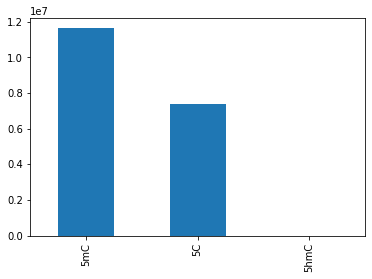

In [197]:
df.label.value_counts().plot(kind='bar')

Text(0, 0.5, 'Cytosine state Counts')

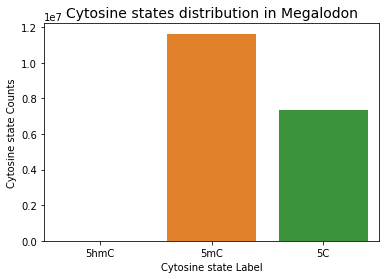

In [198]:
##Show the cytosine states distribution
import seaborn as sns
import matplotlib.pyplot as plt 

sns.countplot(x=df['label'])
sns.color_palette()
plt.title('Cytosine states distribution in Megalodon', fontsize=14)
plt.xlabel('Cytosine state Label')
plt.ylabel('Cytosine state Counts')

In [199]:
label_percentage = df['label'].value_counts(1, sort=False) * 100
label_percentage

5hmC     0.010933
5mC     61.204026
5C      38.785041
Name: label, dtype: float64

In [214]:
# Create label column
# Createa a label with representations: 5C = 0, 5mC = 1, 5hmC = 2
df['label'] = df['label'].map({'5C':0, '5mC':1, '5hmC':2 })
df

,chr,start,read_id,strand,5hmC_prob,5mC_prob,5C_prob,label
0,KJ477685.1,204,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.435397,0.085058,0.479545,2
1,KJ477685.1,261,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.342189,0.500821,0.156990,2
2,KJ477685.1,261,fe8be0cc-f4c4-49f1-80db-c840a6c7dfe9,-,0.577034,0.057676,0.365290,2
3,KJ477685.1,266,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.065316,0.861569,0.073115,2
4,KJ477685.1,266,fe8be0cc-f4c4-49f1-80db-c840a6c7dfe9,-,0.794235,0.028885,0.176880,2
...,...,...,...,...,...,...,...,...
7368253,J02459.1,48437,bd8c6e78-3f60-4793-8cdb-4acab951cffc,-,0.021668,0.003740,0.974592,0
7368254,J02459.1,48437,c739ad62-ce9b-4b1e-877b-d967d74be8ce,-,0.041209,0.003507,0.955284,0
7368255,J02459.1,48437,d864c055-5ca1-433e-b808-f9d0ab560a6f,-,0.031700,0.013814,0.954486,0
7368256,J02459.1,48437,ede4c2d5-d198-42ca-af83-b67b35f052ae,-,0.057225,0.002346,0.940429,0


In [215]:
df['label'].value_counts()

1    11627345
0     7368258
2        2077
Name: label, dtype: int64

In [217]:
df.to_csv(os.path.join(input_path, 'total.Megalodon.per_read.prob.bed'), sep='\t', index = None)

# Feature extraction
https://www.kaggle.com/raviolli77/random-forest-in-python

In [202]:
#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array
print('The probability features set: ')
print(df_feature)
print('The label variable: ')
print(df_class)

The probability features set: 
[[0.43539682 0.0850578  0.47954538]
 [0.34218898 0.50082132 0.1569897 ]
 [0.5770338  0.05767577 0.36529042]
 ...
 [0.03170044 0.01381372 0.95448584]
 [0.0572247  0.00234637 0.94042893]
 [0.02381167 0.00274749 0.97344084]]
The label variable: 
[2 2 2 ... 0 0 0]


# Random forest - Standard approach(baseline), no oversampling

Apply stratified sampling, ensuring splitting the data randomly and keeping the same imbalanced class distribution for each subset.

https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb

Attention!!! I will try with SMOTE later

In [210]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from statistics import mean

# https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb
# Build the random forest model
example_params = {
        'n_estimators': 100,
        'max_depth': 3,
        'random_state': 42
    }

rf_model = RandomForestClassifier(**example_params)
print('test1')
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
print('test2')
#Randomly spilt dataset to traing/testing dataset with the original ratio
X_train, X_test, y_train, y_test = train_test_split(df_feature, 
                                                    df_class, 
                                                    test_size=0.2, 
                                                    stratify=df_class)
print('test3')

test1
test2
test3


In [213]:

#https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb
scoring = ('accuracy', 'recall_macro', 'f1_macro')

#Evaluate SRF model
#scores = cross_validate(rf_model, X_train, y_train, scoring=scoring, cv=cv)
#print('test4')

#Get average evaluation metrics
#print('Mean accuracy: %.3f' % mean(scores['test_accuracy']))
#print('Mean recall_macro: %.3f' % mean(scores['test_recall_macro']))
#print('Mean f1_macro: %.3f' % mean(scores['test_f1_macro']))

cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='recall_macro', n_jobs=-1)
print('test4')

KeyboardInterrupt: 

In [167]:
#Create confusion matrix
fig = plot_confusion_matrix(rf_model, X_test, y_test, display_labels=['5C', '5mC', '5hmC'], cmap='Greens')
plt.title('Standard Random Forest Confusion Matrix')
plt.show()

array([[-1.41378978, -1.09433986],
       [-1.1785108 , -1.58251586],
       [-1.97507026, -1.85349255],
       ...,
       [-0.60110683, -0.24307109],
       [-1.07464132, -1.01954006],
       [-0.50662359, -0.17107237]])

# SMOTE (Synthetic Minority Oversampling Technique) using Standard Random Forest

In [66]:
df_T4.shape, df_lambda.shape, df_5mClambda.shape

((2077, 8), (7368258, 8), (11627345, 8))

In [75]:
max_sample = max(df_T4.shape[0], df_lambda.shape[0],df_5mClambda.shape[0])
max_sample

11627345

In [76]:
df_T4_upsample = resample(df_T4,
                          replace=True,     # sample with replacement
                          n_samples=max_sample,    # to match majority class
                          random_state=123) # reproducible results
df_lambda_upsample = resample(df_lambda,
                             replace=True,     # sample with replacement
                              n_samples=max_sample,    # to match majority class
                              random_state=123)
df_5mClambda_upsample = resample(df_5mClambda,
                                 replace=True,     # sample with replacement
                                 n_samples=max_sample,    # to match majority class
                                 random_state=123)

In [81]:
df_upsampled = pd.concat([df_T4_upsample, df_5mClambda_upsample, df_lambda_upsample])
df_upsampled['label'].value_counts()

5C      11627345
5hmC    11627345
5mC     11627345
Name: label, dtype: int64

# Feature extraction
The feature matrix have 3 features: P(5hmC), P(5mC), P(5C)